In [2]:
def unzip(zip_path = '/content/archive.zip', extract_to = '/content/data/'):
    import zipfile
    import os

    # UNZIP THE FILE INTO A 'DATA' FOLDER
    # Unzipping the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print("Files extracted to:", extract_to)

    # Optionally, list the files in the directory to confirm
    for dirname, _, filenames in os.walk(extract_to):
        for filename in filenames:
            print(os.path.join(dirname, filename))

In [9]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from tqdm import tqdm

class DataLoading():
    def __init__(self, json_path):
        # read file
        self.df = pd.read_json(json_path, lines=True)
        plt.rcdefaults()

    # perform exploratory data analysis
    def EDA(self):
        # Basic info
        print("Dataset size:", self.df.shape)
        print("First few rows:")
        print(self.df.head())
        print("Null value check:")
        print(self.df.isnull().sum())

        # Class balance
        print("Class distribution:")
        print(self.df['is_sarcastic'].value_counts(normalize=True))

        # Text length analysis
        self.df['headline_length'] = self.df['headline'].apply(lambda x: len(x.split()))
        self.df['headline_char_count'] = self.df['headline'].apply(len)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(self.df['headline_length'], bins=30, kde=True)
        plt.title('Headline Length Distribution')
        plt.subplot(1, 2, 2)
        sns.histplot(self.df['headline_char_count'], bins=30, kde=True)
        plt.title('Headline Character Count Distribution')
        plt.show()

        # Word frequency analysis (example with unigrams)
        cv = CountVectorizer(stop_words='english')
        words = cv.fit_transform(self.df['headline'])
        sum_words = words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        top_words = words_freq[:10]
        print("Top words and their counts:")
        print(top_words)

        # Barplot for most commonly occuring words:
        words, counts = zip(*top_words)

        # Creating the bar plot
        plt.figure(figsize=(10, 8))  # Adjust the figure size as per your needs
        plt.bar(words, counts, color='skyblue')  # Change the color as you like
        plt.title('Top 10 Most Common Words')  # Title of the plot
        plt.xlabel('Words')  # X-axis label
        plt.ylabel('Counts')  # Y-axis label
        plt.xticks(rotation=45)  # Rotate the words on x-axis for better readability
        plt.show()  # Display the plot


        # Word cloud for sarcastic headlines
        sarcastic_df = self.df[self.df['is_sarcastic'] == 1]
        all_sarcastic_words = ' '.join(text for text in sarcastic_df['headline'])
        wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_sarcastic_words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()



class ConstructandTrain():
    def __init__(self, df, max_length = 100, vocab_size = 10000):
        self.df = df
        self.max_length = max_length
        self.vocab_size = vocab_size

    def Tokenize(self):
        # Parameters
        trunc_type = 'post'
        padding_type = 'post'
        oov_tok = "<OOV>"

        # Tokenization
        tokenizer = Tokenizer(num_words= self.vocab_size, oov_token=oov_tok)
        tokenizer.fit_on_texts(self.df['headline'])
        sequences = tokenizer.texts_to_sequences(self.df['headline'])
        # print(sequences)

        # Get padded, tokenized data
        self.padded = pad_sequences(sequences, maxlen=self.max_length, padding=padding_type, truncating=trunc_type)

    def build_model(self, embedding_dim = 16):

        # Model definition
        self.model = Sequential([

            # Create a word embedding layer
            Embedding(self.vocab_size, embedding_dim, input_length = self.max_length),

            # Create an LSTM layer with output size 64
            Bidirectional(LSTM(64)),

            # Fully connected output from the LSTM
            Dense(24, activation='relu'),

            # Use sigmoid activation for binary classification
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.summary()

    def split_and_train(self, test_size = 0.2, num_epochs = 10):
        # Splitting the dataset
        X_train, X_test, y_train, y_test = train_test_split(self.padded, self.df['is_sarcastic'], test_size=test_size, random_state=42)

        print('\nTraining for 10 epochs.\n')
        # Training
        self.model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test))

        # Evaluate the model
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f'Loss: {loss}, Accuracy: {accuracy}')



Files extracted to: /content/data/
/content/data/Sarcasm_Headlines_Dataset.json
/content/data/Sarcasm_Headlines_Dataset_v2.json
Dataset size: (26709, 3)
First few rows:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
Null value check:
article_link    0
headline        0
is_sarcastic    0
dtype: i

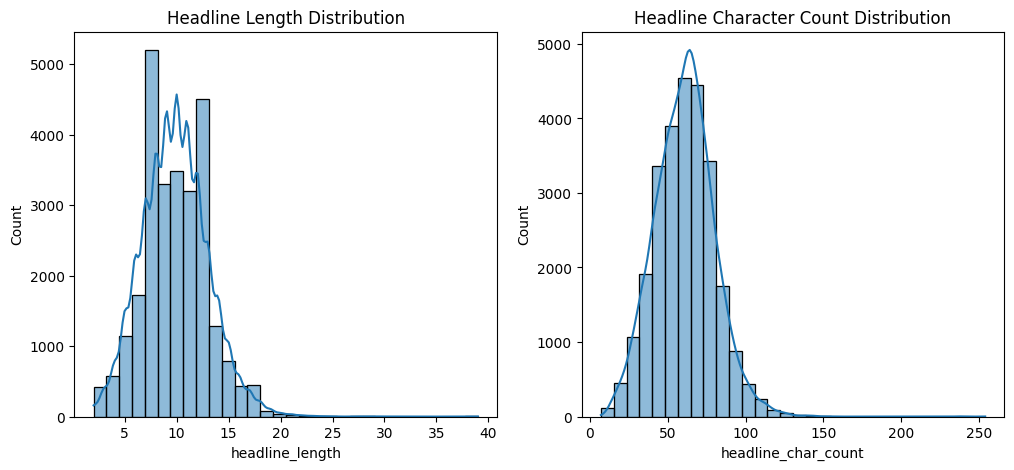

Top words and their counts:
[('trump', 1684), ('new', 1523), ('man', 1395), ('just', 579), ('year', 552), ('report', 515), ('area', 491), ('woman', 481), ('donald', 474), ('day', 471)]
Top words and their counts:
[('trump', 1684), ('new', 1523), ('man', 1395), ('just', 579), ('year', 552), ('report', 515), ('area', 491), ('woman', 481), ('donald', 474), ('day', 471)]


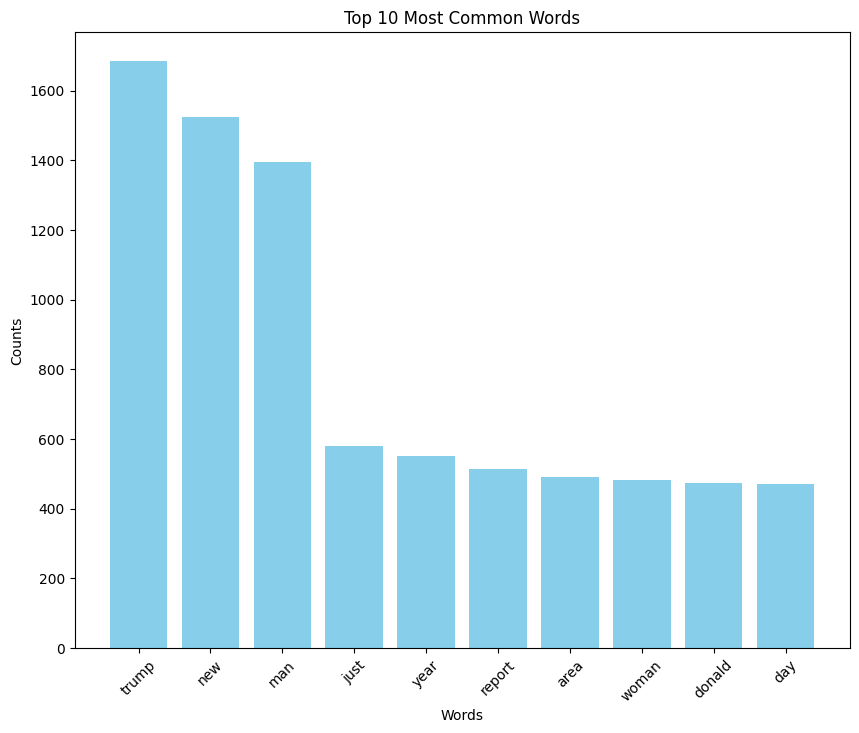

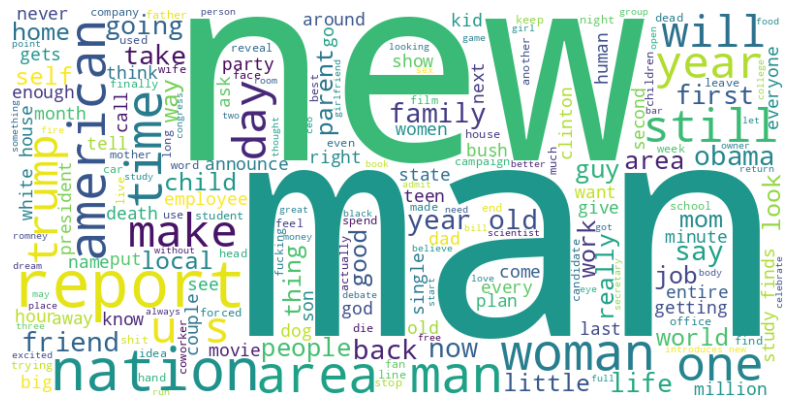

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 128)               41472     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 204593 (799.19 KB)
Trainable params: 204593 (799.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Training for 10 epochs.

Epoch 1/10
668/668 [==============================] - 86

In [ ]:
# The script entry point
if __name__ == '__main__':
    # !pip install tensorflow numpy pandas matplotlib # may or may not want this in if running in colab

    # upload the zip file
    from google.colab import files
    uploaded = files.upload()

    # unzip after uploading, change path if necessary
    unzip(zip_path = '/content/archive.zip', extract_to = '/content/data/')

    # again, change path if necessary
    data_path = '/content/data/Sarcasm_Headlines_Dataset.json'
    data_loader = DataLoading(data_path)
    df = data_loader.df

    # perform exploratory data analysis
    data_loader.EDA()

    # modelling
    lstm = ConstructandTrain(df)
    lstm.Tokenize() # tokenize and pad the sequences
    lstm.build_model()
    lstm.split_and_train()
